# Analysis pipeline for Specificity

## Preliminaries

In [1]:
%cd ~/code/textrec/

/Users/kcarnold/code/textrec


In [2]:
import datetime
import json
import pathlib

import pandas as pd
import numpy as np
import toolz
from IPython.display import Image, HTML

In [3]:
from textrec.paths import paths
from textrec import analysis_util, util, notebook_util, automated_analyses
reload(analysis_util), reload(util), reload(notebook_util), reload(automated_analyses)

Loading COCO captions
Loading COCO id2url
Done


/Users/kcarnold/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Loading ONMT models...
coco_lm_adam_acc_46.00_ppl_16.32_e10_nooptim.pt
Loading model parameters.
coco_cap_adam_acc_48.73_ppl_12.56_e10_nooptim.pt
Loading model parameters.
Ready.
Loading SpaCy...done
Loading COCO captions
Loading COCO id2url
Done
Loading SpaCy...done


(<module 'textrec.analysis_util' from '/Users/kcarnold/code/textrec/src/textrec/analysis_util.py'>,
 <module 'textrec.util' from '/Users/kcarnold/code/textrec/src/textrec/util.py'>,
 <module 'textrec.notebook_util' from '/Users/kcarnold/code/textrec/src/textrec/notebook_util.py'>,
 <module 'textrec.automated_analyses' from '/Users/kcarnold/code/textrec/src/textrec/automated_analyses.py'>)

In [4]:
from textrec.notebook_util import images, id2img, id2url, show_images

In [5]:
# HTML(show_images([images_by_split['val'][0]['cocoid']]))

## Load results of writing experiment

In [167]:
%run -m textrec.batch_analysis

In [168]:
participants = get_participants_by_batch()
participants.keys()

dict_keys(['2018-04-09', '2018-04-24', '2018-04-27', '2018-05-02-invalid', '2018-05-02-old', '2018-05-02'])

In [169]:
len(participants['2018-05-02'])

25

In [170]:
analyses = analyze_all(participants['2018-05-02'])

Randomization counts
norecs,general,specific    6
general,norecs,specific    4
norecs,specific,general    4
general,specific,norecs    4
specific,norecs,general    3
specific,general,norecs    3
Name: conditions, dtype: int64


In [171]:
analyses['trial_level'].columns

Index(['participant', 'age', 'english_proficiency', 'gender',
       'helpfulRank-accurate-least-condition',
       'helpfulRank-accurate-least-idx', 'helpfulRank-accurate-most-condition',
       'helpfulRank-accurate-most-idx', 'helpfulRank-quick-least-condition',
       'helpfulRank-quick-least-idx', 'helpfulRank-quick-most-condition',
       'helpfulRank-quick-most-idx', 'helpfulRank-specific-least-condition',
       'helpfulRank-specific-least-idx', 'helpfulRank-specific-most-condition',
       'helpfulRank-specific-most-idx', 'other_exp', 'techDiff_exp',
       'use_predictive', 'verbalized_during', 'NFC', 'Extraversion', 'block',
       'condition', 'effort', 'frustration', 'mental', 'other_block',
       'performance', 'physical', 'sys-accurate', 'sys-fast', 'sys-specific',
       'techDiff_block', 'temporal', 'TLX_sum', 'characters_per_sec',
       'delay_before_start', 'idx', 'idx_in_block', 'logprob_conditional',
       'logprob_unconditional', 'num_adj', 'num_resized', 'num_

In [154]:
%matplotlib inline

In [172]:
globals().update(analyses)

In [173]:
import seaborn as sns

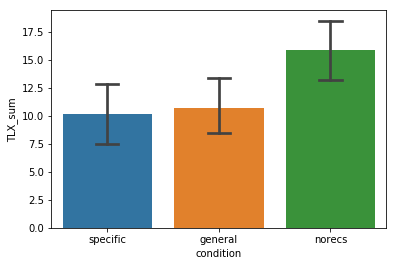

In [174]:
sns.barplot(x='condition', y='TLX_sum', data=block_level, capsize=.2)

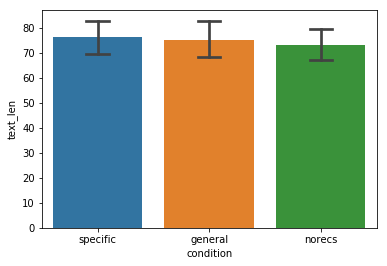

In [176]:
sns.barplot(x='condition', y='text_len', data=trial_level, capsize=.2)

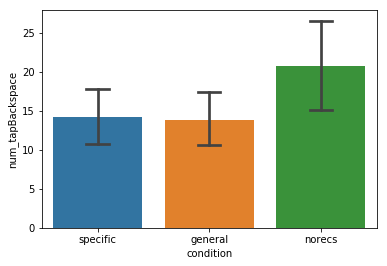

In [177]:
sns.barplot(x='condition', y='num_tapBackspace', data=trial_level, capsize=.2)

In [114]:
# summarize('2018-05-02')

In [117]:
len(list(toolz.pluck('text', trial_data))), len(set(toolz.pluck('participant', trial_data)))

(216, 24)

In [178]:
len(trial_level), len(block_level)

216

In [122]:
helpful_ranks_by_condition

name,accurate-least-condition,accurate-most-condition,quick-least-condition,quick-most-condition,specific-least-condition,specific-most-condition
norecs,19,2,22,2,20,2
general,2,4,1,5,2,6
specific,4,19,2,18,3,17


In [123]:
helpful_ranks_by_idx

name,accurate-least-idx,accurate-most-idx,quick-least-idx,quick-most-idx,specific-least-idx,specific-most-idx
0,10,6,11,7,9,7
1,8,8,7,6,7,8
2,7,11,7,12,9,10


In [179]:
experiment_level['NFC'].describe()

count    25.000000
mean      0.272800
std       0.125151
min       0.040000
25%       0.200000
50%       0.280000
75%       0.360000
max       0.480000
Name: NFC, dtype: float64

In [180]:
experiment_level['Extraversion'].describe()

count    25.000000
mean      0.043200
std       0.163878
min      -0.300000
25%      -0.040000
50%       0.060000
75%       0.140000
max       0.340000
Name: Extraversion, dtype: float64

In [126]:
experiment_level_pivot.columns

Index(['age', 'english_proficiency', 'gender',
       'helpfulRank-accurate-least-condition',
       'helpfulRank-accurate-least-idx', 'helpfulRank-accurate-most-condition',
       'helpfulRank-accurate-most-idx', 'helpfulRank-quick-least-condition',
       'helpfulRank-quick-least-idx', 'helpfulRank-quick-most-condition',
       'helpfulRank-quick-most-idx', 'helpfulRank-specific-least-condition',
       'helpfulRank-specific-least-idx', 'helpfulRank-specific-most-condition',
       'helpfulRank-specific-most-idx', 'other', 'techDiff', 'use_predictive',
       'verbalized_during', 'NFC', 'Extraversion'],
      dtype='object', name='name')

In [131]:
block_level_pivot = decode_block_level(block_level)

In [132]:
block_level_pivot

name                         effort  frustration  mental  \
participant block condition                                
26w4jv      0     specific        0            0       0   
            1     general         0            0       0   
            2     norecs          4            0       3   
3267ww      0     specific        1            1       1   
            1     norecs          5            1       5   
            2     general         1            1       1   
36x2r3      0     norecs          1            2       1   
            1     specific        1            2       1   
            2     general         1            2       1   
4ggxj8      0     norecs          2            2       2   
            1     general         2            1       2   
            2     specific        2            2       1   
533r6c      0     general         1            2       1   
            1     norecs          6            1       0   
            2     specific        6            0       1   
559x69      0     norecs          5            3       4   
            1     general         3            2       3   
            2     specific        3            3       2   
5c39rx      0     specific        1            0       1   
            1     general         0            0       0   
            2     norecs          4            3       4   
5jj59g      0     norecs          4            2       4   
            1     specific        4            1       4   
            2     general         3            1       3   
692c8j      0     norecs          2            1       3   
            1     general         4            2       0   
            2     specific        2            3       2   
74v545      0     norecs          5            3       5   
            1     general         5            3       5   
            2     specific        4            4       4   
...                             ...          ...     ...   
fvwhpc      0     general         3            0       3   
            1     specific        3            0       3   
            2     norecs          4            1       4   
gg65g6      0     general         4            1       5   
            1     norecs          5            1       6   
            2     specific        2            0       1   
gvwqp6      0     norecs          2            0       2   
            1     general         1            0       1   
            2     specific        0            1       0   
gw3w72      0     norecs          2            0       2   
            1     general         3            1       2   
            2     specific        1            1       3   
h52x67      0     specific        5            5       3   
            1     norecs          2            1       4   
            2     general         4            2       1   
jvccx2      0     general         5            0       1   
            1     norecs          5            2       3   
            2     specific        1            0       1   
phqcw9      0     specific        3            3       4   
            1     general         3            4       3   
            2     norecs          3            3       4   
qmwvwv      0     specific        4            1       4   
            1     norecs          4            2       4   
            2     general         4            1       3   
vxjcf7      0     general         3            1       2   
            1     specific        1            0       0   
            2     norecs          5            4       5   
wf4c3m      0     general         3            0       0   
            1     specific        1            0       0   
            2     norecs          0            0       0   

name                                                                     other  \
participant block condition                                                      
26w4jv      0     specific                             

In [133]:
print('\n\n'.join(x for x in experiment_level_pivot['techDiff'] if x is not None))

None

Mone

No

No

No issues

No 

No

No

No

Nope

None.

No

Just the fact that the third photo in keyboard 1 never loaded.

None

No. 


In [134]:
print('\n\n'.join(x for x in experiment_level_pivot['other'] if x is not None))

No, I really enjoyed this task ☺️

None

It went well but my initial survey responses might not be in complete alignment with my final responses on this page.  That's because seeing my captions on this page gave me a better perspective with the benefit of hindsight.  Thanks for the HIT!  I did my best and hope the data is useful!

Being able to not have to backspace to redo typing

This was very annoying

Everything was great. First and third were pretty equal. Second was awful.

It went smooth no issues 

Everything went smoothly. Thank you

Can I type this one on the computer? One: I love the fact that after going to this page straight from the HIT on my computer, the page stayed synced when I went to it from my phone. There are some HITs I've done that could really benefit from that little nicety. Two: I feel like the suggestions really tend toward making me lazy, to some small extent. Having to type it all, you have to think about what to say, whereas faced with suggested options, 

In [141]:
pd.merge(
    experiment_level_pivot.reset_index(),
    block_level_pivot.reset_index(),
    on='participant',
    suffixes=('_explevel', '_blocklevel'),
    validate='1:m')

name,participant,age,english_proficiency,gender,helpfulRank-accurate-least-condition,helpfulRank-accurate-least-idx,helpfulRank-accurate-most-condition,helpfulRank-accurate-most-idx,helpfulRank-quick-least-condition,helpfulRank-quick-least-idx,...,mental,other_blocklevel,performance,physical,sys-accurate,sys-fast,sys-specific,techDiff_blocklevel,temporal,TLX_mean
0,26w4jv,37,Native or bilingual,Female,specific,0,specific,0,norecs,2,...,0,None,0,0,6,6,6,None,0,0
1,26w4jv,37,Native or bilingual,Female,specific,0,specific,0,norecs,2,...,0,None,1,0,4,3,3,None,0,1
2,26w4jv,37,Native or bilingual,Female,specific,0,specific,0,norecs,2,...,3,None,1,4,2,0,3,None,3,15
3,3267ww,28,Fluent,Female,norecs,1,specific,0,norecs,1,...,1,None,1,1,6,6,6,None,1,6
4,3267ww,28,Fluent,Female,norecs,1,specific,0,norecs,1,...,5,None,3,4,1,1,1,None,1,19
5,3267ww,28,Fluent,Female,norecs,1,specific,0,norecs,1,...,1,None,1,1,6,5,5,None,3,8
6,36x2r3,24,Native or bilingual,Female,general,2,specific,1,general,2,...,1,None,1,1,2,1,1,No,2,8
7,36x2r3,24,Native or bilingual,Female,general,2,specific,1,general,2,...,1,None,1,0,2,2,4,None,1,6
8,36x2r3,24,Native or bilingual,Female,general,2,specific,1,general,2,...,1,None,1,0,2,1,2,None,1,6
9,4ggxj8,43,Native or bilingual,Male,specific,2,norecs,0,norecs,0,...,2,This is an outstanding HIT!,1,0,6,4,5,No,2,9


In [88]:
participant_id = participants['2018-05-02'][0]
analyzed = analysis_util.get_log_analysis(participant_id)

In [99]:
page_data = analyzed['byExpPage']['final-0-0']

In [100]:
page_data['firstEventTimestamp']

1525278736019

In [94]:
actions = ['actions']
timestamps = [action['jsTimestamp'] / 1000 for action in actions]
np.diff(timestamps)

array([7.78800011, 0.13899994, 0.602     , 0.14600015, 0.0389998 ,
       0.08500004, 0.17900014, 0.12899995, 0.38400006, 0.12299991,
       1.04399991, 0.28100014, 0.22000003, 0.12299991, 0.23000002,
       0.12100005, 0.21300006, 0.12199998, 0.05299997, 0.12800002,
       0.04900002, 0.12599993, 1.36599994, 0.148     , 2.54900002,
       0.10800004, 0.02200007, 0.10099983, 0.23600006, 0.13199997,
       0.4690001 , 0.13699985, 0.50400019, 0.15199995, 0.19199991,
       0.13499999, 0.08599997, 0.13300014, 0.21199989, 0.13800001,
       0.02900004, 0.10500002, 0.06399989, 0.14300013, 2.31599998,
       0.13199997, 0.05599999, 0.13700008, 0.07399988, 0.12800002,
       0.35000014, 0.12799978, 0.08100009, 0.12000012, 0.51899981,
       0.14700007, 0.18199992, 0.12300014, 0.24099994, 0.12700009,
       0.04799986, 0.12700009, 1.0769999 , 0.15300012, 1.15899992,
       0.1329999 , 1.43500018, 0.15799999, 0.11999989, 0.33500004,
       0.13700008, 0.12899995, 0.12199998, 0.02600002, 0.14199

In [98]:
analyzed['screenTimes']

[{'num': 0, 'timestamp': 1525278516611, 'name': 'Welcome'},
 {'num': 1, 'timestamp': 1525278551374, 'name': 'IntroSurvey'},
 {'num': 2, 'timestamp': 1525278566895, 'name': 'TaskDescription'},
 {'num': 3, 'timestamp': 1525278639223, 'name': 'StudyDesc'},
 {'num': 4, 'timestamp': 1525278671098, 'name': 'Instructions'},
 {'num': 5, 'timestamp': 1525278672686, 'name': 'ExperimentScreen'},
 {'num': 6, 'timestamp': 1525278730840, 'name': 'PostPractice'},
 {'num': 7, 'timestamp': 1525278736019, 'name': 'ExperimentScreen'},
 {'num': 8, 'timestamp': 1525278786804, 'name': 'ExperimentScreen'},
 {'num': 9, 'timestamp': 1525278879110, 'name': 'ExperimentScreen'},
 {'num': 10, 'timestamp': 1525279593679, 'name': 'PostTaskSurvey'},
 {'num': 11, 'timestamp': 1525279692649, 'name': 'Instructions'},
 {'num': 12, 'timestamp': 1525279694001, 'name': 'ExperimentScreen'},
 {'num': 13, 'timestamp': 1525279733949, 'name': 'PostPractice'},
 {'num': 14, 'timestamp': 1525279735704, 'name': 'ExperimentScreen'},


In [101]:
Counter(action['type'] for action in page_data['actions'])

Counter({'backendReply': 60,
         'tapKey': 53,
         'tapSuggestion': 4,
         'tapBackspace': 3})

# Generate nAFC task

For each stimulus image, choose a foil set. It should be about equally difficult for each condition. Simplest approach: find the nearest caption to the concatenation of all captions we got for that image.

TODO: should we be computing similarities of individual captions, rather than complete images?

In [24]:
cap_vectorizer, caption_vecs = util.get_vectorized_captions()

In [25]:
caption_vecs.shape

(123287, 9952)

In [26]:
id2url[570528]

'http://images.cocodataset.org/train2017/000000570528.jpg'

In [27]:
concat_captions = {stimulus: '\n'.join(toolz.pluck('text', trials))
                   for stimulus, trials in toolz.groupby('stimulus', trial_data).items()}
concat_captions.keys()

dict_keys([275449, 396295, 431140, 227326, 200451, 223777, 247576, 71815, 240275])

In [28]:
# print(concat_captions[71815])
# print(concat_captions[275449])
print(concat_captions[396295])

a small bath with a shower with a blue mat on the floor
someome is using a shower but it's hard to see due to the opaque glass
i see a standing shower with two hazy sliding glass doors and a towel hanging off of one.
a tan towel hangs in front of a glass shower
brown towel is hanging on a sliding shower door
a beige towel hangs over the rightmost shower door both of which are wet with water
a closed shower door with crackled glass encases some hanging colored toiletries
a rusty and dirty shower in the bathroom has a tan towel over its handle
a sliding glass shower door with a bath mat hanging on it
a shower with a towel hanging on the handle of the door
a tan towel is hanging from a chrome handle on a textured glass shower door
a person is taking a shower in a shower with very opaque sliding doors
a bathroom towel hanging on a shower door with a toilet in view
a beige towel hangs up on the outside of an enclosed shower containing toiletries
a shower door
a toilet and a shower door hang

For 275449, the foil images are fixated on the 'wine'. But unsurprising, since all but one caption mentions it, and it's probably less common than "cat".

In [31]:
def get_similar_images(caption, n=10):
    query_vec = cap_vectorizer.transform([caption])
    similarity = caption_vecs.dot(query_vec.T).A.ravel()
    return [images[idx]['cocoid'] for idx in np.argsort(similarity)[-n:][::-1]]
query_caption = concat_captions[396295].replace('wine', '') #trial_data[0]['text']
# query_caption = "a rusty and dirty shower in the bathroom has a tan towel over its handle"
# query_caption = "a sliding glass shower door with a bath mat hanging on it"
query_caption = "a closed shower door with crackled glass encases some hanging colored toiletries"
# print(query_caption)
# HTML(show_images(get_similar_images(query_caption)))

In [32]:
def get_foil_set(*, stimulus, caption, rs):
    similar_images = get_similar_images(caption, n=10)
    if stimulus not in similar_images:
        print("Inserting", stimulus, 'into foil set')
        similar_images[-1] = stimulus
    rs.shuffle(similar_images)
    return similar_images
stimulus = trial_data[1]['stimulus']
get_foil_set(stimulus=stimulus, caption=concat_captions[stimulus], rs=np.random.RandomState(1234))

[490872, 233737, 372775, 396295, 409842, 262284, 503200, 510852, 98257, 212082]

In [33]:
rs = np.random.RandomState(1234)
foil_sets = {
    stimulus: get_foil_set(stimulus=stimulus, caption=concat_captions[stimulus], rs=rs)
    for stimulus in sorted(concat_captions.keys())}

Inserting 200451 into foil set
Inserting 240275 into foil set
Inserting 431140 into foil set


Group tasks so that (1) each annotator never gets the same target image twice and (2) each annotator never sees two captions from the same person. The latter criterion cannot always be met, though, since the number of annotators may not evenly divide the number of participants.

In [48]:
import random
def shuffled(lst):
    lst = lst[:]
    random.shuffle(lst)
    return lst

In [82]:
while True:
    trials_by_img = toolz.groupby('stimulus', shuffled(trial_data))
    annotators = []
    while not any(len(trials) == 0 for trials in trials_by_img.values()):
        trials_for_annotator = []
        participants_seen_by_annotator = set()
        for stimulus, trials in trials_by_img.items():
            for i in range(len(trials)):
                participant = trials[i]['participant']
                if participant not in participants_seen_by_annotator:
                    trials_for_annotator.append(trials.pop(i))
                    participants_seen_by_annotator.add(participant)
                    break
            else:
#                 print("Have to use the same participant again")
                trials_for_annotator.append(trials.pop(0))

        annotators.append(shuffled(trials_for_annotator))
    if all(len(set(toolz.pluck('participant', trials))) == len(trials) for trials in annotators):
        break
    assert all(len(trials) == 0 for trials in trials_by_img.values())

In [83]:
a = annotators[:]

In [84]:
trials_by_img

{71815: [],
 227326: [],
 247576: [],
 223777: [],
 240275: [],
 275449: [],
 431140: [],
 200451: [],
 396295: []}

Check that each annotator never gets the same target image twice

In [85]:
assert all(len(set(toolz.pluck('stimulus', trials))) == len(trials) for trials in annotators)

Check that each annotator never sees two captions from the same person.

In [86]:
assert all(len(set(toolz.pluck('participant', trials))) == len(trials) for trials in annotators)

In [87]:
[len(trials) for trials in annotators]

[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]

In [89]:
len(annotators)

24

In [90]:
def make_task(stimulus, text):
    foil_set = foil_sets[stimulus]
    return dict(
        description=text,
        correct_idx=foil_set.index(stimulus),
        images=[id2url[idx] for idx in foil_set]
    )

In [91]:
trial = annotators[0][0]
make_task(trial['stimulus'], trial['text'])

{'description': 'dozens of people line the gray sidewalks adjacent to tall buildings as a two deck bus and vehicle progress on the street',
 'correct_idx': 2,
 'images': ['http://images.cocodataset.org/train2017/000000200447.jpg',
  'http://images.cocodataset.org/train2017/000000578233.jpg',
  'http://images.cocodataset.org/train2017/000000247576.jpg',
  'http://images.cocodataset.org/train2017/000000050752.jpg',
  'http://images.cocodataset.org/train2017/000000024600.jpg',
  'http://images.cocodataset.org/train2017/000000551983.jpg',
  'http://images.cocodataset.org/train2017/000000318107.jpg',
  'http://images.cocodataset.org/train2017/000000282343.jpg',
  'http://images.cocodataset.org/train2017/000000059611.jpg',
  'http://images.cocodataset.org/train2017/000000360528.jpg']}

In [115]:
guesses_task = pd.DataFrame([
    json.dumps([make_task(trial['stimulus'], trial['text']) for trial in annotator_trials])
    for annotator_trials in annotators], columns=['task'])
guesses_task.iloc[:1].to_csv(str(paths.data / 'anno-tasks' / 'guesses_test.csv'), index=False)
guesses_task.iloc[1:].to_csv(str(paths.data / 'anno-tasks' / 'guesses_remain.csv'), index=False)
guesses_task.to_csv(str(paths.data / 'anno-tasks' / 'guesses.csv'), index=False)

### Load MTurk results so far

In [263]:
result_files = list((paths.data / 'mturk').glob('*-guesses.csv'))
batched_guesses_results = (
    pd.concat([pd.read_csv(str(f)) for f in result_files], axis=0, ignore_index=True)
)

In [264]:
%matplotlib inline

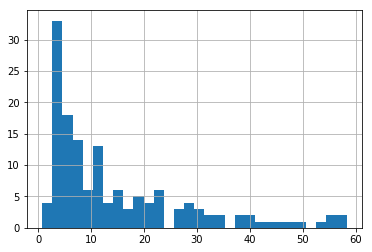

In [265]:
(batched_guesses_results['WorkTimeInSeconds']/60).hist(bins=30)

count    141.000000
mean       3.541477
std        1.978311
min        1.289233
25%        2.376467
50%        3.031583
75%        4.121867
max       15.050567
Name: Answer.results, dtype: float64

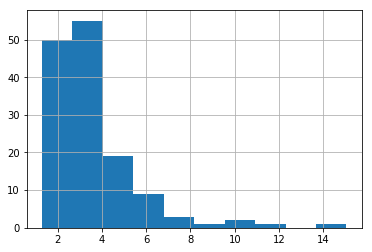

In [273]:
def get_active_dur(results):
    pages = json.loads(results)
    try:
        first_guess = pages[0]['guesses'][0]['timestamp']
        last_guess = pages[-1]['guesses'][-1]['timestamp']
        return (last_guess - first_guess) / 1000 / 60
    except IndexError:
        # Something failed in the UI probably...
        return None
batched_guesses_results['Answer.results'].apply(get_active_dur).hist()
batched_guesses_results['Answer.results'].apply(get_active_dur).describe()
        

In [272]:
batched_guesses_results[batched_guesses_results['Answer.results'].apply(lambda x: '"guesses":[]' in x)].T

,92,102,127
AcceptTime,Tue May 22 14:49:42 PDT 2018,Tue May 22 14:50:27 PDT 2018,Tue May 22 14:53:55 PDT 2018
Answer.doNotRedirect,NaN,NaN,NaN
Answer.feedback,"not very long, but it was a little confusing.",NO COMMENTS,NOTHING
Answer.results,"[{""pageIdx"":0,""description"":""looking down a lo...","[{""pageIdx"":0,""description"":""a tennis player a...","[{""pageIdx"":0,""description"":""a towel folded ov..."
ApprovalTime,NaN,NaN,NaN
Approve,NaN,NaN,NaN
AssignmentDurationInSeconds,3600,3600,3600
AssignmentId,3YHH42UU5BFCFW5Q64TTZGBH8MG0L1,31Z0PCVWUKFEGKDF0CGT0MVLAD7T7W,3IOEN3P9S7JU30N1FJRRO2CUNJX612
AssignmentStatus,Submitted,Submitted,Submitted
AutoApprovalDelayInSeconds,259200,259200,259200


In [267]:
%debug

> <ipython-input-266-7084eaa7ce6a>(3)get_active_dur()
      1 def get_active_dur(results):
      2     pages = json.loads(results)
----> 3     first_guess = pages[0]['guesses'][0]['timestamp']
      4     last_guess = pages[-1]['guesses'][-1]['timestamp']
      5     return (last_guess - first_guess) / 1000 / 60

ipdb> p results
'[{"pageIdx":0,"description":"looking down a london street on a crowded evening with a london double bus in clear focus and old-style buildings next to each other on both sides","guesses":[],"images":[{"idx":7,"url":"http://images.cocodataset.org/train2017/000000282343.jpg","isCorrect":false,"alreadyGuessed":false},{"idx":0,"url":"http://images.cocodataset.org/train2017/000000200447.jpg","isCorrect":false,"alreadyGuessed":false},{"idx":6,"url":"http://images.cocodataset.org/train2017/000000318107.jpg","isCorrect":false,"alreadyGuessed":false},{"idx":4,"url":"http://images.cocodataset.org/train2017/000000024600.jpg","isCorrect":false,"alreadyGuessed":false},{"id

ipdb> q


In [278]:
guesses_results = []
for i, row in batched_guesses_results.iterrows():
    for page in json.loads(row['Answer.results']):
#         print(page)
        guess_indices = [guess['idx'] for guess in page['guesses']]
        if len(guess_indices) == 0:
            print("UI fail", row['WorkerId'])
            continue
#         guessed_right_sometime = [row.correctIdx in row.guess_indices for row in mturk_nafc_results.itertuples()]
        stimulus_url = [img for img in page['images'] if img['isCorrect']][0]['url']
        guesses_results.append(dict(
            guesser=row['WorkerId'],
            description=page['description'],
            num_guesses=len(guess_indices),
            stimulus_url=stimulus_url))
pd.DataFrame(guesses_results)

UI fail A27TKWMGFUCDMY
UI fail A27TKWMGFUCDMY
UI fail A27TKWMGFUCDMY
UI fail A27TKWMGFUCDMY
UI fail A27TKWMGFUCDMY
UI fail A27TKWMGFUCDMY
UI fail A27TKWMGFUCDMY
UI fail A27TKWMGFUCDMY
UI fail A27TKWMGFUCDMY
UI fail A3343ON7H5UO3L
UI fail A3343ON7H5UO3L
UI fail A3343ON7H5UO3L
UI fail A3343ON7H5UO3L
UI fail A3343ON7H5UO3L
UI fail A3343ON7H5UO3L
UI fail A3343ON7H5UO3L
UI fail A3343ON7H5UO3L
UI fail A111ZFNLXK1TCO
UI fail A111ZFNLXK1TCO
UI fail A111ZFNLXK1TCO
UI fail A111ZFNLXK1TCO
UI fail A111ZFNLXK1TCO
UI fail A111ZFNLXK1TCO
UI fail A111ZFNLXK1TCO
UI fail A111ZFNLXK1TCO


,description,guesser,num_guesses,stimulus_url
0,dozens of people line the gray sidewalks adjac...,A89R5XGMHOTJE,1,http://images.cocodataset.org/train2017/000000...
1,a newly wedded couple cutting there wedding ca...,A89R5XGMHOTJE,1,http://images.cocodataset.org/train2017/000000...
2,a man with blonde hair and a white and black w...,A89R5XGMHOTJE,1,http://images.cocodataset.org/train2017/000000...
3,people are standing on the beach flying colorf...,A89R5XGMHOTJE,4,http://images.cocodataset.org/train2017/000000...
4,a train is coming on a rail road,A89R5XGMHOTJE,6,http://images.cocodataset.org/train2017/000000...
5,a tricolor cat is sitting in front of a partia...,A89R5XGMHOTJE,3,http://images.cocodataset.org/train2017/000000...
6,a closed shower door with crackled glass encas...,A89R5XGMHOTJE,1,http://images.cocodataset.org/train2017/000000...
7,a tennis player in a white shirt and tan short...,A89R5XGMHOTJE,1,http://images.cocodataset.org/train2017/000000...
8,a bathroom with a toilet and sink and with a r...,A89R5XGMHOTJE,1,http://images.cocodataset.org/val2017/00000043...
9,dozens of people line the gray sidewalks adjac...,A1DKVUTOBPQH11,2,http://images.cocodataset.org/train2017/000000...


In [ ]:
num_responses_by_caption = mturk_nafc_results.groupby('Answer.description').size().to_dict()

### Generate tasks remaining

In [ ]:
# trials_todo = [trial for trial in trial_data if num_responses_by_caption.get(trial['text'], 0) < 3]
# len(trial_data), len(trials_todo)

In [ ]:
# i = 0
# while True:
#     out_fn = paths.data / 'anno-tasks' / f'{datetime.date.today().isoformat()}-{i}-nAFC.csv'
#     if not out_fn.exists():
#         break
#     i += 1
# out_fn

In [ ]:
# rs = np.random.RandomState(1234)
# pd.DataFrame([make_task(trial, rs) for trial in trials_todo]).to_csv(out_fn, index=False)

### Generate the actual HIT text...

In [ ]:
from jinja2 import Template
html = Template(open(paths.top_level / 'HITs' / '2018-05-04-image-description-match.jinja.html').read()).render(dict(
    description='${description}',
    images=['${image_%d_url}' % i for i in range(10)]))

In [ ]:
html2 = html
trial = trial_data[18+7*9]
for k, v in make_task(trial['stimulus'], trial['text']).items():
    html2 = html2.replace('${' + k + '}', str(v))
HTML('<div style="height: 1000px; position: relative;">'+html2+'</div>')
# print(html2)

In [ ]:
import subprocess
subprocess.Popen('pbcopy', stdin=subprocess.PIPE).communicate(html.encode('utf-8'))

# Analyze MTurk results

In [ ]:
mturk_nafc_results.groupby('Answer.description').num_guesses.mean().to_dict()

In [ ]:
%matplotlib inline

In [ ]:
(mturk_nafc_results['WorkTimeInSeconds'][mturk_nafc_results['WorkTimeInSeconds'] < 5*60] / 60).hist(bins=30)

In [ ]:
np.median(mturk_nafc_results['WorkTimeInSeconds'] / 60) * 9/60

In [ ]:
(
    15 # participants
    * 3 # conditions per participant
    * 3 # captions per condition
    - 1 # image not shown
) * 3 # annotators per description


In [ ]:
    * .24 # reward per annotator
) * 1.2 # MTurk 20% fee

Did the same worker see the same target image multiple times?

In [ ]:
next(data.iterrows())[1]['Input.image_0_url']

In [ ]:
mturk_nafc_results['target_image_url'] = [row['Input.image_'+str(row['correctIdx'])+"_url"] for _, row in mturk_nafc_results.iterrows()]

In [ ]:
bad_worker_image_pairs = set()
for worker_id, data in mturk_nafc_results.groupby('WorkerId'):
    target_images = [row['target_image_url'] for _, row in data.iterrows()]
    if len(target_images) != len(set(target_images)):
#         print(worker_id)
        value_counts = pd.Series(target_images).value_counts()
        value_counts = value_counts[value_counts > 1]
#         print(value_counts)
        for img in value_counts.index:
            bad_worker_image_pairs.add((worker_id, img))
bad_worker_image_pairs

annotation_row_is_bad = [
    (row['WorkerId'], row['target_image_url']) in bad_worker_image_pairs
    for _, row in mturk_nafc_results.iterrows()
]
mturk_nafc_results['row_is_bad'] = annotation_row_is_bad

In [ ]:
mturk_nafc_results['row_is_bad'].mean()

In [ ]:
guess_results = mturk_nafc_results[~mturk_nafc_results['row_is_bad']].rename(columns={'Answer.description': 'text'})

In [ ]:
len(mturk_nafc_results)

In [ ]:
len(guess_results), len(trial_data)

In [ ]:
trial_data

In [260]:
annotator_level_data = pd.merge(
    pd.DataFrame(trial_data).rename(columns={'participant': 'writer'}),
    guess_results.rename(columns={'WorkerId': 'guesser'}).drop(['HITId', 'HITTypeId', 'Title', 'Description', 'Keywords', 'RequesterAnnotation', 'guesses'], axis=1),
    on='text', validate='1:m', how='right')
annotator_level_data
    #.groupby().num_guesses.mean().to_frame('mean_num_guesses'),
#     left_on='text', right_index=True).groupby('condition').mean_num_guesses.aggregate(['mean', 'std'])

NameError: name 'guess_results' is not defined

In [279]:
guesses_results[0]

{'guesser': 'A89R5XGMHOTJE',
 'description': 'dozens of people line the gray sidewalks adjacent to tall buildings as a two deck bus and vehicle progress on the street',
 'num_guesses': 1,
 'stimulus_url': 'http://images.cocodataset.org/train2017/000000247576.jpg'}

In [280]:
annotator_level_data = pd.merge(
    pd.DataFrame(trial_data).rename(columns={'participant': 'writer'}),
    pd.DataFrame(guesses_results).rename(columns={'description': 'text'}),
    on='text', validate='1:m', how='right')
annotator_level_data
    #.groupby().num_guesses.mean().to_frame('mean_num_guesses'),
#     left_on='text', right_index=True).groupby('condition').mean_num_guesses.aggregate(['mean', 'std'])

,block,condition,exclude,idx,idx_in_block,num_resized,num_tapBackspace,num_tapKey,num_tapSugg_any,num_tapSugg_bos,num_tapSugg_full,num_tapSugg_part,num_tapText,writer,stimulus,text,guesser,num_guesses,stimulus_url
0,0,general,False,0,0,NaN,6.0,86.0,6,NaN,NaN,6.0,1.0,jvccx2,275449,a yellow cat with strips is setting on a place...,A1TARNH07A75CG,1,http://images.cocodataset.org/train2017/000000...
1,0,general,False,0,0,NaN,6.0,86.0,6,NaN,NaN,6.0,1.0,jvccx2,275449,a yellow cat with strips is setting on a place...,A3GEL5PWFIK05S,1,http://images.cocodataset.org/train2017/000000...
2,0,general,False,0,0,NaN,6.0,86.0,6,NaN,NaN,6.0,1.0,jvccx2,275449,a yellow cat with strips is setting on a place...,A185P3B2MC2K83,1,http://images.cocodataset.org/train2017/000000...
3,0,general,False,0,0,NaN,6.0,86.0,6,NaN,NaN,6.0,1.0,jvccx2,275449,a yellow cat with strips is setting on a place...,A3774HPOUKYTX7,1,http://images.cocodataset.org/train2017/000000...
4,0,general,False,0,0,NaN,6.0,86.0,6,NaN,NaN,6.0,1.0,jvccx2,275449,a yellow cat with strips is setting on a place...,A1PDBRYBFMMFNY,1,http://images.cocodataset.org/train2017/000000...
5,0,general,False,0,0,NaN,6.0,86.0,6,NaN,NaN,6.0,1.0,jvccx2,275449,a yellow cat with strips is setting on a place...,AZJKB1D4AFMQY,1,http://images.cocodataset.org/train2017/000000...
6,0,general,False,1,1,2.0,2.0,46.0,4,1.0,NaN,3.0,NaN,jvccx2,396295,a small bath with a shower with a blue mat on ...,A3VENK02U0X16N,1,http://images.cocodataset.org/train2017/000000...
7,0,general,False,1,1,2.0,2.0,46.0,4,1.0,NaN,3.0,NaN,jvccx2,396295,a small bath with a shower with a blue mat on ...,AJRY9ALX8069Y,1,http://images.cocodataset.org/train2017/000000...
8,0,general,False,1,1,2.0,2.0,46.0,4,1.0,NaN,3.0,NaN,jvccx2,396295,a small bath with a shower with a blue mat on ...,A3L2FPKRD46FRW,1,http://images.cocodataset.org/train2017/000000...
9,0,general,False,1,1,2.0,2.0,46.0,4,1.0,NaN,3.0,NaN,jvccx2,396295,a small bath with a shower with a blue mat on ...,A2VAL2BRKVSUB5,1,http://images.cocodataset.org/train2017/000000...


In [281]:
annotator_level_data.columns

Index(['block', 'condition', 'exclude', 'idx', 'idx_in_block', 'num_resized',
       'num_tapBackspace', 'num_tapKey', 'num_tapSugg_any', 'num_tapSugg_bos',
       'num_tapSugg_full', 'num_tapSugg_part', 'num_tapText', 'writer',
       'stimulus', 'text', 'guesser', 'num_guesses', 'stimulus_url'],
      dtype='object')

In [284]:
annotator_level_data.to_csv('annotator_level_data_2018-05-22v2.csv', index=False)

In [285]:
(annotator_level_data['num_guesses'] == 1).mean()

0.5381589299763966

In [283]:
%pwd

'/Users/kcarnold/code/textrec'

In [286]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [287]:
%%R
library(lme4)
library(ggplot2)

In [288]:
%%R -i annotator_level_data
(model = lmer(num_guesses ~ condition + (1|writer) + (1|guesser) + (1|stimulus), annotator_level_data))

Linear mixed model fit by REML ['lmerMod']
Formula: num_guesses ~ condition + (1 | writer) + (1 | guesser) + (1 |  
    stimulus)
   Data: annotator_level_data
REML criterion at convergence: 5530.827
Random effects:
 Groups   Name        Std.Dev.
 guesser  (Intercept) 0.5323  
 writer   (Intercept) 0.5333  
 stimulus (Intercept) 0.5996  
 Residual             2.0263  
Number of obs: 1271, groups:  guesser, 143; writer, 24; stimulus, 9
Fixed Effects:
      (Intercept)    conditionnorecs  conditionspecific  
          2.54278           -0.20093           -0.06277  


In [289]:
%%R -i annotator_level_data
(null_model = lmer(num_guesses ~ (1|writer) + (1|guesser) + (1|stimulus), annotator_level_data))

Linear mixed model fit by REML ['lmerMod']
Formula: num_guesses ~ (1 | writer) + (1 | guesser) + (1 | stimulus)
   Data: annotator_level_data
REML criterion at convergence: 5528.521
Random effects:
 Groups   Name        Std.Dev.
 guesser  (Intercept) 0.5365  
 writer   (Intercept) 0.5320  
 stimulus (Intercept) 0.6032  
 Residual             2.0256  
Number of obs: 1271, groups:  guesser, 143; writer, 24; stimulus, 9
Fixed Effects:
(Intercept)  
      2.455  


In [290]:
%%R
library(pbkrtest)

In [291]:
%%R
(kr <- KRmodcomp(model, null_model))

F-test with Kenward-Roger approximation; computing time: 3.05 sec.
large : num_guesses ~ condition + (1 | writer) + (1 | guesser) + (1 | 
    stimulus)
small : num_guesses ~ (1 | writer) + (1 | guesser) + (1 | stimulus)
           stat       ndf       ddf F.scaling p.value
Ftest    1.0214    2.0000 1234.8701   0.99999  0.3604


In [ ]:
%%R -i annotator_level_data
(glm.full = glmer(num_guesses ~ condition + (1|writer) + (1+guesser) + (1|stimulus), annotator_level_data, family=poisson()))

In [ ]:
%%R
(glm.null = glmer(num_guesses ~ (1|writer) + (1+guesser) + (1|stimulus), annotator_level_data, family=poisson()))

In [ ]:
%%R
#confint(glm.full)

In [ ]:
%%R
anova(glm.full, glm.null, test="Chisq")

In [ ]:
%%R -i annotator_level_data
(nb_model = glmer.nb(num_guesses ~ condition + (1|writer) + (1+guesser) + (1|stimulus), annotator_level_data))

In [ ]:
%%R -i annotator_level_data
(nb_model.null = glmer.nb(num_guesses ~ (1|writer) + (1+guesser) + (1|stimulus), annotator_level_data))

In [ ]:
%%R
anova(nb_model, nb_model.null, test="Chisq")

In [ ]:
results = pd.DataFrame([dict(trial, specificity=specificity_lookup[trial['text'].strip()]) for trial in trial_data])
for col in ['condition', 'participant']:
    results[col] = results[col].astype('category')
results.info()

In [ ]:
results.groupby('condition').specificity.mean()

In [ ]:
pd.DataFrame(trial_data).sample(frac=1.0).sort_values('stimulus').to_csv('trial_data_by_stimulus.csv')

# How many images does this caption apply to?

In [ ]:
data = pd.read_csv("/Users/kcarnold/Downloads/Submitted Captions - Sheet1.csv").iloc[:,:6]

In [ ]:
data

In [ ]:
data.shape

In [ ]:
data = data.dropna().copy()
data.shape

In [ ]:
data['is_unique'] = (data.iloc[:,5] == '1')
data.is_unique.mean()

In [ ]:
data.groupby(['block', 'idx_in_block', 'condition']).is_unique.mean()

In [ ]:
data['participant'] = data['participant'].astype('category')
data['condition'] = data['condition'].astype('category')

In [ ]:
data.groupby('condition').is_unique.mean()

In [ ]:
%%R -i data
transformed <- art(is_unique ~ condition + (1|participant), data=data)
summary(transformed)
anova(transformed)

In [ ]:
example = trial_data[-1]['text']
example

Concepts: traffic light. COCO doesn't have "pedestian crossing sign". There are 4330 images with traffic lights in them in COCO. That's way too much. Looking at Visual Genome.

Visual Genome synsets are potentially best, but they're sometimes inaccurate. e.g., "18 wheeler" is "cyclist.n.01". So let's consider an object a match if matches either the synset or object name.

In [ ]:
vg_base = pathlib.Path('/Data/VisualGenome')
image_objects = json.load(open(vg_base / 'objects.json'))

In [ ]:
img_by_id = {img['image_id']: img for img in image_objects}

In [ ]:
obj_synsets = json.load(open(vg_base / 'object_synsets.json'))

In [ ]:
obj_attributes = json.load(open(vg_base / 'attributes.json'))

In [ ]:
len(obj_attributes), len(image_objects)

In [ ]:
obj_attributes[0].keys()

In [ ]:
attributes_by_img = {att['image_id']: att['attributes'] for att in obj_attributes}

In [ ]:
attributes_by_img[61514]

In [ ]:
# def has_object(obj_name):
#     return {
#         img['image_id'] for img in image_objects
#         if any(obj_name in '\n'.join(obj['names']) for obj in img['objects'])
#            }
def has_object(imgid, obj_name):
    return any(obj_name in '\n'.join(obj['names']) for obj in attributes_by_img[imgid])

In [ ]:
# def has_synset(obj_synset):
#     return {
#         img['image_id'] for img in image_objects
#         if any(obj_synset in obj['synsets'] for obj in img['objects'])}
def has_synset(imgid, obj_synset):
    return any(obj_synset in obj['synsets'] for obj in attributes_by_img[imgid])

In [ ]:
def has_obj_with_attr(imgid, obj_name, attr):
    return any(
        (obj_name in '\n'.join(obj['names'])) and (attr in obj.get('attributes', []))
        for obj in attributes_by_img[imgid])

def has_synset_with_attr(imgid, obj_synset, attr):
    return any(
        (obj_synset in obj['synsets']) and (attr in obj.get('attributes', []))
        for obj in attributes_by_img[imgid])

def has_obj_without_attr(imgid, obj_name, attr):
    return any(
        (obj_name in '\n'.join(obj['names'])) and (attr not in obj.get('attributes', []))
        for obj in attributes_by_img[imgid])

def has_synset_without_attr(imgid, obj_synset, attr):
    return any(
        (obj_synset in obj['synsets']) and (attr not in obj.get('attributes', []))
        for obj in attributes_by_img[imgid])

In [ ]:
obj_synsets['pedestrian sign']

In [ ]:
# candidates = (
#     (has_object('pedestrian sign') | has_object('pedestrian crossing sign') | has_object('crossing sign') | has_object('sign')) &
#     (has_object('traffic light') | has_synset('traffic_light.n.01'))
# )
candidates = {
    imgid for imgid in attributes_by_img.keys()
    if (
        (
            has_object(imgid, 'pedestrian sign') |
            has_object(imgid, 'pedestrian crossing sign') |
            has_object(imgid, 'crossing sign') |
            has_obj_with_attr(imgid, 'sign', 'yellow')
        ) & (
            has_obj_without_attr(imgid, 'traffic light', 'red') |
            has_synset_without_attr(imgid, 'traffic_light.n.01', 'red')
        ))}
len(candidates)

In [ ]:
show_images(candidates)

In [ ]:
[img['image_id'] for img in image_objects if '61514' in img.get('image_url', '')]
#Image(img_by_id[61514]['image_url'])

In [ ]:
img_by_id[61514]

# Measuring Specificity

We use paired comparisons to analyze specificity and accuracy. For a target image $x$ and a fixed set of imposter images $Y$, the **specific accuracy** of a caption is the fraction of comparisons that chose $x$. 

We start with our dataset of paired comparisons.

In [ ]:
captions = [
    "exactly how are both the dog and the person going to fit on that skateboard?",
    "the dark haired dog is trying to ride on the skateboard.",
    "a person in shorts and a black dog both have one foot on a skateboard.",
    "a dog with a black head and black legs and ears standing up has one black paw on a black skateboard with white wheels and a guy with black and white shoes and white socks has one foot on the skateboard also and there are bikes and other people in the background"
]

In [ ]:
alternatives = 'dog-and-guy-on-skateboard just-dog-on-skateboard guy-on-skateboard-holding-dog dog-and-guy-next-to-skateboard'.split()
target = alternatives[0]
imposters = alternatives[1:]
applies_to = [
    'dog-and-guy-on-skateboard dog-and-guy-next-to-skateboard'.split(),
    'just-dog-on-skateboard'.split(),
    'dog-and-guy-on-skateboard'.split(),
    'dog-and-guy-on-skateboard just-dog-on-skateboard guy-on-skateboard-holding-dog dog-and-guy-next-to-skateboard'.split()
]
applies_to = {cap: tgts for cap, tgts in zip(captions, applies_to)}
applies_to

In [ ]:
import random
random.seed(0)
pairs = [[target, imposter] for imposter in imposters]
for pair in pairs:
    random.shuffle(pair)
pairs

In [ ]:
def fake_answer_pairs_for_caption(applies, pairs):
    outcomes = []
    for a, b in pairs:
        choices = []
        if a in applies:
            choices.append(0)
        if b in applies:
            choices.append(1)
        if len(choices) == 0:
            choices = [0, 1]
        outcomes.append(random.choice(choices))
    return outcomes
fake_answer_pairs_for_caption(applies_to[captions[0]], pairs)

In [ ]:
fake_comparisons_data = []
for caption in captions:
    for annotator in range(5):
        for pair, outcome in zip(pairs, fake_answer_pairs_for_caption(applies_to[caption], pairs)):
            picked = pair[outcome]
            fake_comparisons_data.append(dict(
                caption=caption,
                annotator=annotator,
                pair=pair,
                picked=picked))

In [ ]:
data = pd.DataFrame(fake_comparisons_data)
len(data)

In [ ]:
data['picked_correct'] = data['picked'] == 'dog-and-guy-on-skateboard'
data.groupby('caption').picked_correct.mean().sort_values()

# Final analyses

We find a main effect of writing condition on outcome specificity.

In [ ]:
%load_ext rpy2.ipython

In [ ]:
results = pd.DataFrame([
    dict(participant_id=participant_id, condition=condition)
    for participant_id in 'abc def ghi'.split() for condition in 'general specific norecs'.split()
])
results['participant_id'] = results['participant_id'].astype('category')
results['condition'] = results['condition'].astype('category')
results['specificity'] = np.random.randn(len(results))

In [ ]:
%%R
#install.packages("ARTool")
library(ARTool)

In [ ]:
%%R -i results
summary(results)

In [ ]:
%%R -i results
transformed <- art(specificity ~ condition + (1|participant), data=results)
summary(transformed)
anova(transformed)